- Owner: Ignacio Falco
- Proyecto: Resultados de la Fúrmula 1 (2014 - 2024)
- Dataset: Formula 1 World Championship (1950 - 2024)
- Link del dataset: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download

# 0. Especificaciones

Previo a comenzar a desarrollar el trabajo se brindan especificaciones claves para entender ciertas cuestiones en el dataset:

- El dataset original está compuesto por 14 archivos .csv con información histórica de la Fórmula 1 desde sus inicios. Para evitar la carga masiva de archivos directamente en el entorno de trabajo y optimizar el manejo de los datos, se decidió utilizar SQL Server para construir el dataset específico requerido para el proyecto. De esta manera, se pudo integrar la información relevante de forma más eficiente y estructurada. La consulta SQL utilizada para generar este dataset es la siguiente:
  
DROP TABLE IF EXISTS f1_dataset_base;

SELECT
    r.raceId,
    r.year,
    r.round,
    r.date AS race_date,
    c.name AS circuit_name,
    c.location AS circuit_location,
    c.country AS circuit_country,

    d.driverId,
    d.forename + ' ' + d.surname AS driver_name,
    d.nationality AS driver_nationality,
    d.dob AS driver_birthdate,

    cons.constructorId,
    cons.name AS constructor_name,
    cons.nationality AS constructor_nationality,

    res.grid AS starting_position,
    res.positionOrder AS final_position,
    res.positionText,
    res.points,
    s.status,

    q.position AS qualy_position,
    q.q1,
    q.q2,
    q.q3,

     ASE WHEN res.positionOrder = 1
 THEN 1 ELSE 0 END AS
 won_race
INTO f
1_dataset_base
FROM results res
JOIN
 races r ON res.raceId = r.raceId
JOIN driv
ers d ON res.driverId = d.driverId
JOIN constructors cons ON res
.constructorId = cons.constructorId
JOIN cir
cuits c ON r.circuitId = c.circuitId
JOIN 
status s ON res.statusId = s.statusId
LEFT JOIN qualifying q ON res.raceId = 
q.raceId AND res.driv
erId = q.driverId
WHERE r.year >= 2014
ORDER BY r.year, r.round, final_position;


- Se tomó la decisión de analizar los datos a partir de la temporada 2014, ya que ese año marcó un punto de inflexión en la historia reciente de la Fórmula 1 con la introducción de los motores híbridos V6 Turbo. Este cambio representó una transformación profunda en el diseño, la estrategia y el rendimiento de los autos, obligando a cada equipo a adaptarse y reconstruir sus monoplazas en relación a esta nueva tecnología. Por esta razón, centrarse en los datos posteriores a 2014 permite obtener un análisis más coherente y relevante, evitando posibles sesgos derivados de comparar épocas con normativas técnicas sustancialmente diferentes.

# 1. Introducción

## Abstract

El presente proyecto tiene como objetivo principal analizar los factores que influyen en el desempeño de los pilotos en las carreras de Fórmula 1, con especial atención a variables como la posición de clasificación (qualy), los tiempos de clasificación en cada fase (Q1, Q2, Q3), la experiencia del piloto, el equipo constructor y las condiciones de la carrera. A partir de este análisis, se busca desarrollar un modelo predictivo capaz de estimar el piloto ganador de cada carrera, lo que puede ser útil para equipos, analistas deportivos y aficionados interesados en entender y anticipar el comportamiento competitivo en la Fórmula 1.

El dataset utilizado proviene de registros históricos de Fórmula 1, con aproximadamente 4600 registros que contienen información sobre cada piloto en cada carrera, incluyendo datos demográficos, posiciones de salida y llegada, tiempos de clasificación, puntos obtenidos y estado de la carrera. Entre las variables más relevantes se encuentran: año, circuito, piloto, constructor, posición de clasificación, tiempos en Q1, Q2 y Q3, posición final en la carrera, puntos y estado de finalización.

Este conjunto de datos permite explorar cómo distintos factores previos a la carrera y características del piloto afectan su desempeño final. A través de un análisis exploratorio de datos (EDA) se identificarán patrones, relaciones y posibles valores atípicos o faltantes.

Este estudio busca no solo construir un modelo predictivo efectivo para predecir al ganador de cada carrera, sino también ofrecer una interpretación clara y práctica de los factores que más influyen en el resultado, contribuyendo a una mejor comprensión del deporte motor desde una perspectiva analítica.

## Descripción de columnas

- `raceId`: ID único de cada carrera.
- `year`: Año de la carrera.
- `round`: Número de carrera de la temporada.
- `race_date`: Fecha de la carrera.
- `circuitName`: Nombre del circuito.
- `circuitLocation`: Ubicación del circuito.
- `circuitCountry`: País del circuito.
- `driverId`: ID único de cada piloto.
- `driverName`: Nombre del piloto.
- `driverNationality`: Nacionalidad del piloto.
- `driverBirthdate`: Fecha de nacimiento del piloto.
- `constructorId`: ID único de cada constructor (El constructor es la escudería en la que corre el piloto. Por ejemplo Ferrari o Mercedes.)
- `constructorName`: Nombre del constructor.
- `constructorNationality`: Nacionalidad de cada constructor.
- `startingPosition`: Posición inicial del piloto en la carrera.
- `finalPosition`: Posición final del piloto en la carrera.
- `points`: Puntos sumados por el piloto en la carrera.
- `status`: Estado del piloto al finalizar la carrera.
- `qualyPosition`: Posición en la qualy (La qualy es la carrera previa de clasificación que define la posición de salida del piloto en la carrera).
- `q1`: Tiempo del piloto en la primera ronda de la qualy.
- `q2`: Tiempo del piloto en la segunda ronda de la qualy.
- `q3`: Tiempo del piloto en la tercera ronda de la qualy.
- `wonRace`: Indica si el piloto ganó o no la carrera (1=Ganó - 0=No ganó)

## Objetivo principal del modelo

Predecir el piloto ganador.

## Hipótesis iniciales

Hipótesis 1: A mejor posición de largada, mayor es la probabilidad de que un piloto gane la carrera.

Hipótesis 2: Los pilotos que no pasan la Q1 tienden a terminar en peores posiciones finales.

# 2. Carga de datos y primeras vistas

In [103]:
# Importando librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones globales para visualización

sns.set(style="whitegrid")
plt.style.use('ggplot')

In [104]:
# Cargando el dataset y previsualizando los primeros 10 registros

df = pd.read_csv('C:/Users/ignac/OneDrive/Escritorio/Proyecto coder/dataSetProject.csv', delimiter=',')
df.head(10)

,raceId,year,round,race_date,circuit_name,circuit_location,circuit_country,driverId,driver_name,driver_nationality,...,starting_position,final_position,positionText,points,status,qualy_position,q1,q2,q3,won_race
0,980,2017,12,27/8/2017,Circuit de Spa-Francorchamps,Spa,Belgium,8,Kimi Räikkönen,Finnish,...,4,4,4,12.0,Finished,4.0,1:44.729,1:43.700,1:43.270,0
1,940,2015,14,27/9/2015,Suzuka Circuit,Suzuka,Japan,8,Kimi Räikkönen,Finnish,...,6,4,4,12.0,Finished,6.0,1:34.171,1:33.361,1:33.347,0
2,965,2016,18,23/10/2016,Circuit of the Americas,Austin,USA,839,Esteban Ocon,French,...,22,18,18,0.0,+2 Laps,22.0,1:38.806,\N,\N,0
3,1033,2020,3,19/7/2020,Hungaroring,Budapest,Hungary,20,Sebastian Vettel,German,...,5,6,6,8.0,+1 Lap,5.0,1:15.455,1:15.131,1:14.774,0
4,1102,2023,5,7/5/2023,Miami International Autodrome,Miami,USA,839,Esteban Ocon,French,...,8,9,9,2.0,Finished,8.0,1:27.872,1:27.444,1:27.935,0
5,917,2014,18,9/11/2014,Autódromo José Carlos Pace,São Paulo,Brazil,20,Sebastian Vettel,German,...,6,5,5,10.0,Finished,6.0,1:11.880,1:11.129,1:10.938,0
6,1105,2023,7,4/6/2023,Circuit de Barcelona-Catalunya,Montmeló,Spain,839,Esteban Ocon,French,...,6,8,8,4.0,Finished,7.0,1:13.433,1:13.001,1:13.083,0
7,972,2017,4,30/4/2017,Sochi Autodrom,Sochi,Russia,8,Kimi Räikkönen,Finnish,...,2,3,3,15.0,Finished,2.0,1:34.953,1:33.663,1:33.253,0
8,965,2016,18,23/10/2016,Circuit of the Americas,Austin,USA,20,Sebastian Vettel,German,...,6,4,4,12.0,Finished,6.0,1:37.151,1:36.462,1:36.358,0
9,1017,2019,8,23/6/2019,Circuit Paul Ricard,Le Castellet,France,20,Sebastian Vettel,German,...,7,5,5,11.0,Finished,7.0,1:31.075,1:29.506,1:29.799,0


In [105]:
#Renombrando columnas para que todas sigan la misma estructura (Camel Case)

df= df.rename(columns = {
    'race_date': 'raceDate', 
    'circuit_name': 'circuitName', 
    'circuit_location': 'circuitLocation', 
    'circuit_country': 'circuitCountry', 
    'driver_name': 'driverName', 
    'driver_nationality': 'driverNationality',
    'driver_birthdate': 'driverBirthdate',
    'constructor_name': 'constructorName',
    'constructor_nationality': 'constructorNationality',
    'starting_position': 'startingPosition',
    'final_position': 'finalPosition',
    'qualy_position': 'qualyPosition',
    'won_race': 'wonRace'
    }
)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4626 entries, 0 to 4625
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   raceId                  4626 non-null   int64  
 1   year                    4626 non-null   int64  
 2   round                   4626 non-null   int64  
 3   raceDate                4626 non-null   object 
 4   circuitName             4626 non-null   object 
 5   circuitLocation         4626 non-null   object 
 6   circuitCountry          4626 non-null   object 
 7   driverId                4626 non-null   int64  
 8   driverName              4626 non-null   object 
 9   driverNationality       4626 non-null   object 
 10  driverBirthdate         4626 non-null   object 
 11  constructorId           4626 non-null   int64  
 12  constructorName         4626 non-null   object 
 13  constructorNationality  4626 non-null   object 
 14  startingPosition        4626 non-null   

In [107]:
#Verificando si existen valores nulos.
df.isnull().sum()

raceId                     0
year                       0
round                      0
raceDate                   0
circuitName                0
circuitLocation            0
circuitCountry             0
driverId                   0
driverName                 0
driverNationality          0
driverBirthdate            0
constructorId              0
constructorName            0
constructorNationality     0
startingPosition           0
finalPosition              0
positionText               0
points                     0
status                     0
qualyPosition             16
q1                        16
q2                        38
q3                        62
wonRace                    0
dtype: int64

Se puede observar que existen algunos valores nulos en la posición en la clasificación y en los tiempos de Q1, Q2 y Q3. Esto es algo normal ya que hay pilotos que no finalizaron la qualy y hay pilotos que solo hacen la 1 y/o 2 (Depende del tiempo de vuelta para ver si avanzas a las siguiente qualy).

In [108]:
df = df.astype({
    'raceId': 'object', #Modificando los tipos de datos de las columnas "ID" para dear de ser consideradas "int"
    'driverId': 'object', #Modificando los tipos de datos de las columnas "ID" para dear de ser consideradas "int"
    'constructorId': 'object',#Modificando los tipos de datos de las columnas "ID" para dear de ser consideradas "int"
    'points': 'int', #Modificando la columna "points" para que sea tipo "int"
    'qualyPosition': 'Int64' #Modificando la columna "qualyPosition" para que sea tipo "int64" permitiendo mantener los nulos.
})

#Modificando las columnas "raceDate" y "driverBirthdate" para que sean tipo "datetime"
df['raceDate'] = pd.to_datetime(df['raceDate'], format="%d/%m/%Y")
df['driverBirthdate'] = pd.to_datetime(df['driverBirthdate'], format="%d/%m/%Y")


#Modificando los datos de las columnas "q1", "q2" y "q3" a segundos para poder utilizarlas en los análisis de variables númericas.

def tiempoSegundos(t):
    if pd.isna(t) or t == '\\N':
        return np.nan
    if ':' in t:
        minutos, segundos = t.split(':')
        return int(minutos) * 60 + float(segundos)
    return float(t)


# Aplicando la función a las columnas
for col in ['q1', 'q2', 'q3']:
    df[col] = df[col].apply(tiempoSegundos)


In [109]:
df.dtypes

raceId                            object
year                               int64
round                              int64
raceDate                  datetime64[ns]
circuitName                       object
circuitLocation                   object
circuitCountry                    object
driverId                          object
driverName                        object
driverNationality                 object
driverBirthdate           datetime64[ns]
constructorId                     object
constructorName                   object
constructorNationality            object
startingPosition                   int64
finalPosition                      int64
positionText                      object
points                             int32
status                            object
qualyPosition                      Int64
q1                               float64
q2                               float64
q3                               float64
wonRace                            int64
dtype: object

In [110]:
#Verificando si existen valores duplicados
df.duplicated().sum()

0

# 3. Análisis exploratorio (EDA)

## 3.1 Análisis univariado - Variables categóricas

Objetivo: Entender distribución y frecuencia de valores.

In [111]:
#Analizando variables categóricas.

catCol = df.select_dtypes(include=['object']).columns

drop_cols = [
    'raceId', #Al ser IDs únicos no tiene relevancia incluirlo en el EDA.
    'driverId', #Al ser IDs únicos no tiene relevancia incluirlo en el EDA.
    'constructorId', #Al ser IDs únicos no tiene relevancia incluirlo en el EDA.
    'positionText' #Al ser posiciones en la carrera no tiene relevancia incluirlo en el EDA.
]

catCol = catCol.drop(drop_cols)
catCol


Index(['circuitName', 'circuitLocation', 'circuitCountry', 'driverName',
       'driverNationality', 'constructorName', 'constructorNationality',
       'status'],
      dtype='object')

- Pilotos y circuitos:

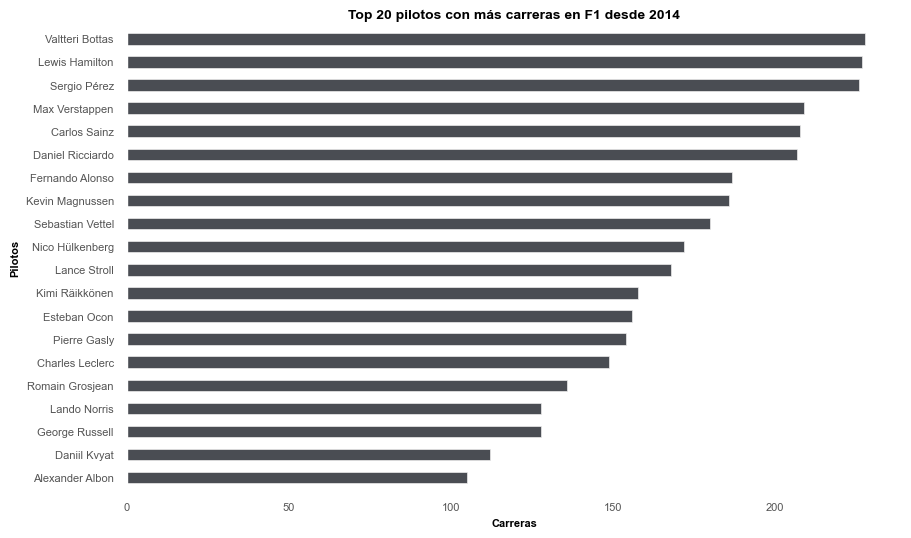

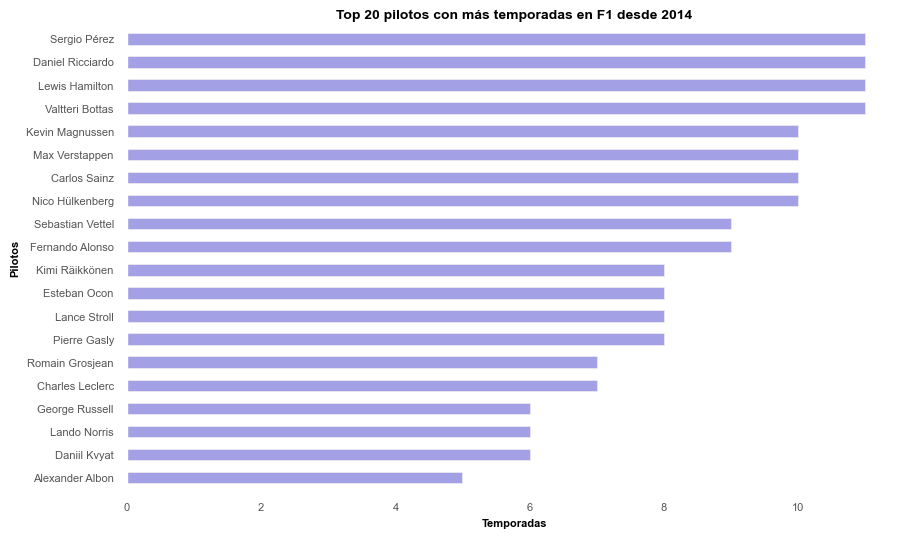

In [112]:
# Graficando cantidad de carreras por piloto para entender la experiencia.

topPilotosCarreras = df['driverName'].value_counts().head(20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#FFFFFF')
topPilotosCarreras.plot(kind='barh', color='#4A4D53')
ax.set_title('Top 20 pilotos con más carreras en F1 desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Carreras', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Pilotos', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)
plt.show()

print('\n' * 1)  # ← Esto agrega 3 saltos de línea entre los gráficos

# Graficando cantidad de temporadas por piloto para entender la longevidad.
pilotosTemporadas = df[['driverName', 'year']].drop_duplicates()
topPilotosTemporadas = pilotosTemporadas['driverName'].value_counts().head(20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#FFFFFF')
topPilotosTemporadas.plot(kind='barh', color='#A4A0E5')
ax.set_title('Top 20 pilotos con más temporadas en F1 desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Temporadas', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Pilotos', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)
plt.show()


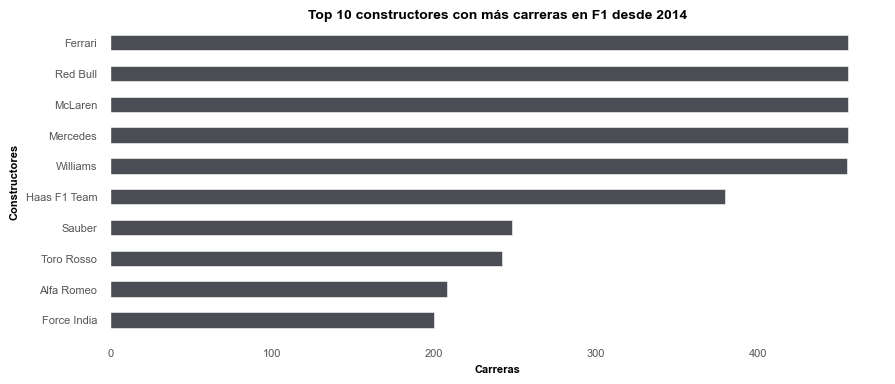

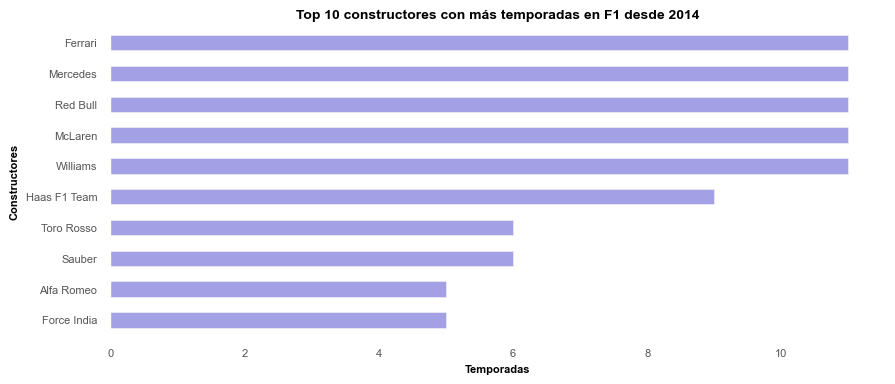

In [113]:
# Graficando cantidad de carreras por constructor para entender la experiencia.

topConstructoresCarreras = df['constructorName'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_facecolor('#FFFFFF')
topConstructoresCarreras.plot(kind='barh', color='#4A4D53')
ax.set_title('Top 10 constructores con más carreras en F1 desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Carreras', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Constructores', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)
plt.show()

print('\n' * 1)  # ← Esto agrega 3 saltos de línea entre los gráficos

# Graficando cantidad de temporadas por constructor para entender la longevidad.
constructoresTemporadas = df[['constructorName', 'year']].drop_duplicates()
topConstructoresTemporadas = constructoresTemporadas['constructorName'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_facecolor('#FFFFFF')
topConstructoresTemporadas.plot(kind='barh', color='#A4A0E5')
ax.set_title('Top 10 constructores con más temporadas en F1 desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Temporadas', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Constructores', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)
plt.show()


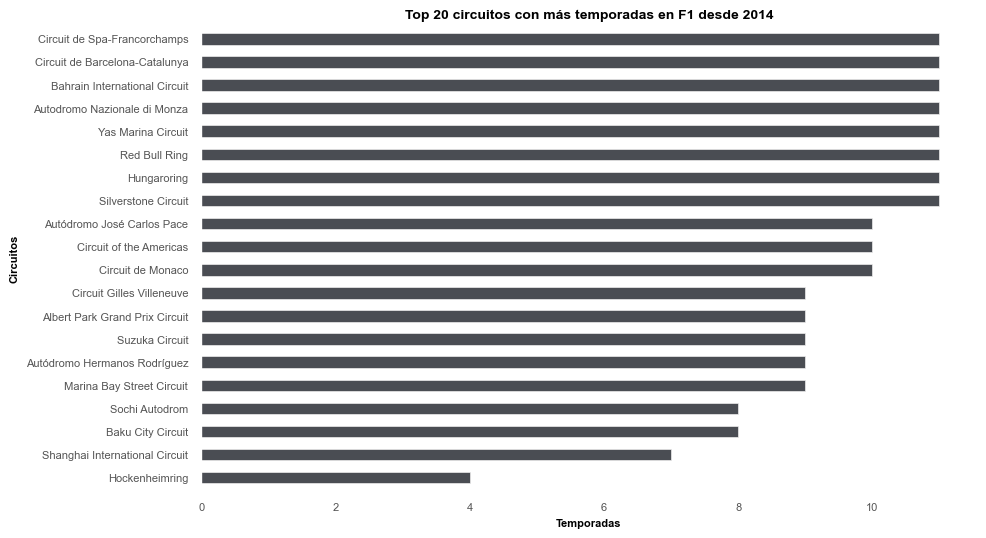

In [114]:
# 1. Creando un df con una fila por circuito y temporada.
circuitUnique = df[['year', 'circuitName']].drop_duplicates()

# 2. Contando cuántas temporadas se corrió en cada circuito.
topCircuitos = circuitUnique['circuitName'].value_counts().head(20)

# 3. Graficando.
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#FFFFFF') 
topCircuitos.plot(kind='barh', color='#4A4D53', ax=ax)
ax.set_title('Top 20 circuitos con más temporadas en F1 desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Temporadas', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Circuitos', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)
plt.show()

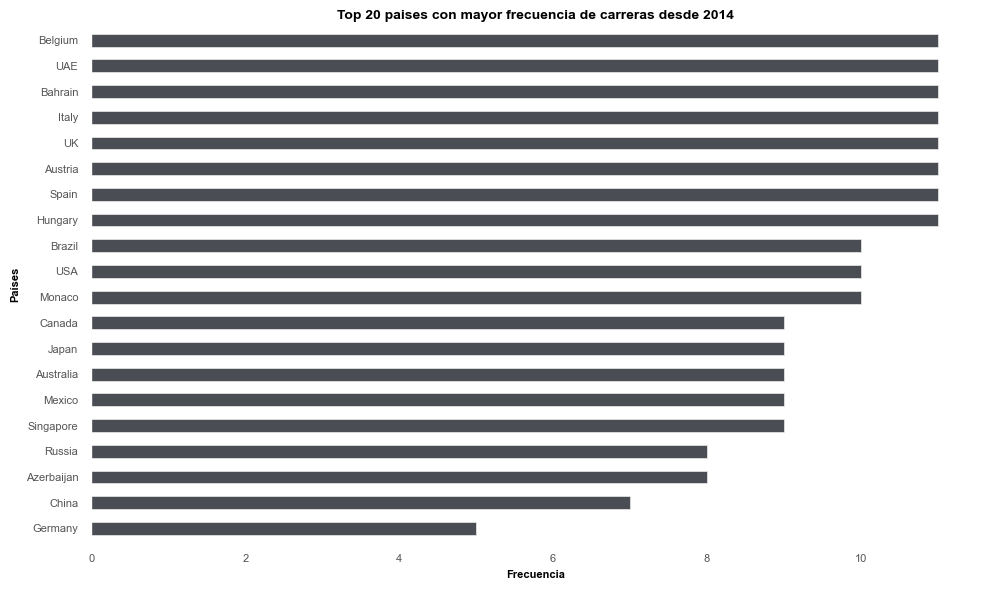

In [115]:
# 1. Creando un df con una fila por país y temporada.
countryUnique = df[['year', 'circuitCountry']].drop_duplicates()

# 2. Contando cuántas temporadas se corrió en cada país.
topCountry = countryUnique['circuitCountry'].value_counts().head(20)

# 3. Graficando.
fig, ax = plt.subplots(figsize=(10, 6))


ax.set_facecolor('#FFFFFF')
topCountry.plot(kind='barh', color='#4A4D53')
ax.set_title('Top 20 paises con mayor frecuencia de carreras desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Frecuencia', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Países', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)

plt.tight_layout()
plt.show()

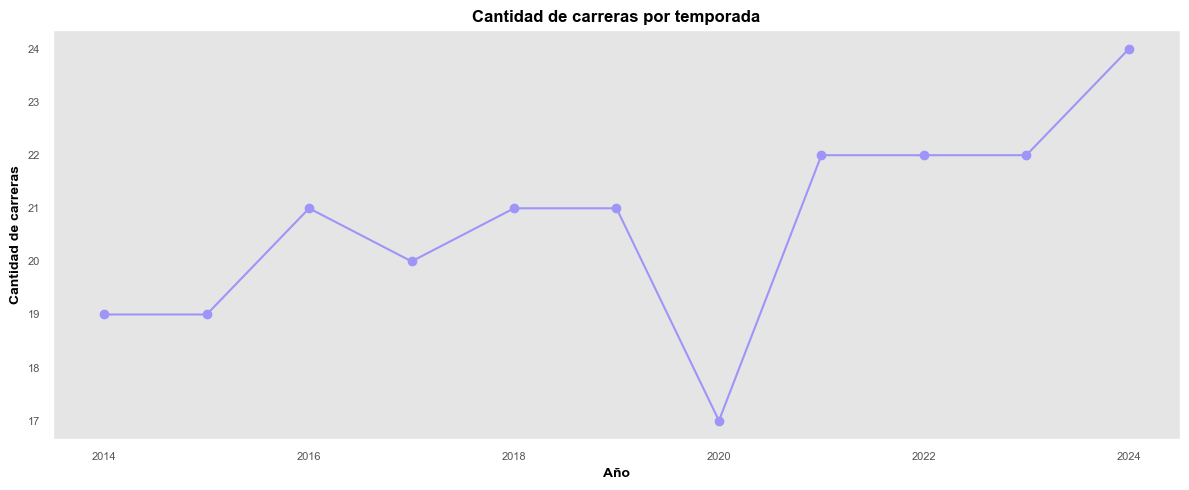

In [116]:
# 1. Graficando cantidad de carreras por temporada.

carrerasPorAnio = df[['year', 'raceId']].drop_duplicates()['year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 5))
carrerasPorAnio.plot(
    kind='line', 
    marker='o', 
    color='#9E95F8', 
    ax=ax
)

ax.set_title('Cantidad de carreras por temporada', fontsize=12, fontweight='bold', color='#000000')
ax.set_xlabel('Año', fontsize=10, fontweight='bold', color='#000000')
ax.set_ylabel('Cantidad de carreras', fontsize=10, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.grid(False)
plt.tight_layout()
plt.show()


- Estado del piloto en la carrera:

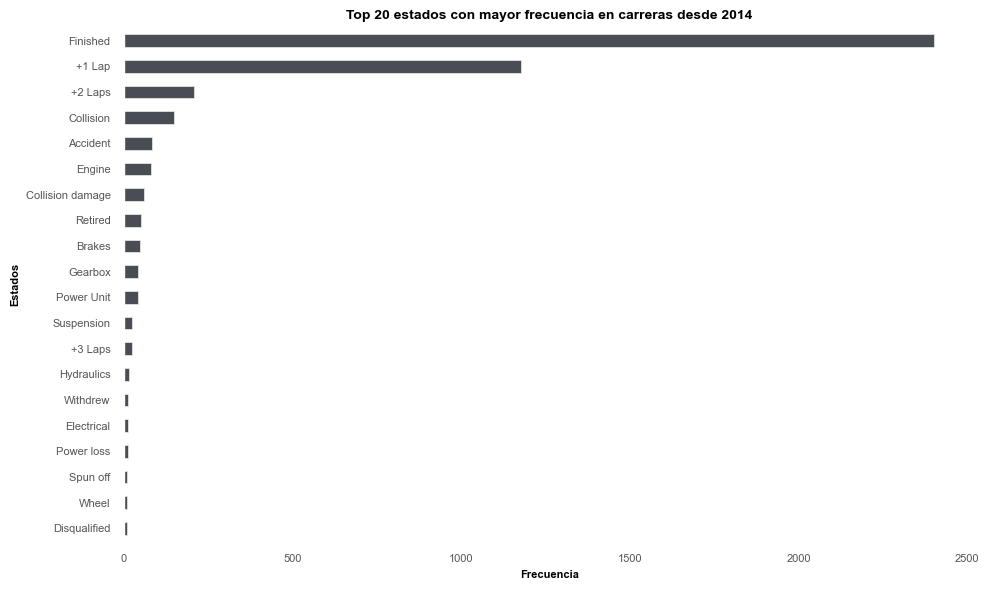

In [117]:
# Graficando la distribución de los distintos estados en la carrera.
statusCounts = df['status'].value_counts().head(20) 

fig, ax = plt.subplots(figsize=(10, 6))


ax.set_facecolor('#FFFFFF')
statusCounts.plot(kind='barh', color='#4A4D53')
ax.set_title('Top 20 estados con mayor frecuencia en carreras desde 2014', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Frecuencia', fontsize=8, fontweight='bold', color='#000000')
ax.set_ylabel('Estados', fontsize=8, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.invert_yaxis()
ax.grid(False)

plt.tight_layout()
plt.show()


- Distribuciones de pilotos y constructores por temporada

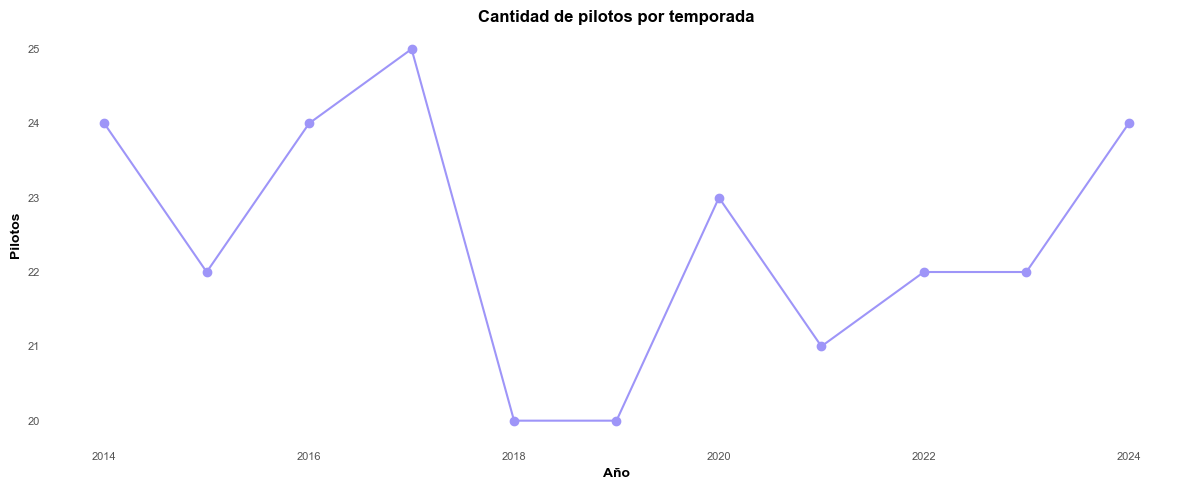

In [118]:
pilotosPorAnio = df.groupby('year')['driverId'].nunique()

fig, ax = plt.subplots(figsize=(12, 5))
pilotosPorAnio.plot(
    kind='line', 
    marker='o', 
    color='#9E95F8', 
    ax=ax
)

ax.set_facecolor('#FFFFFF')
ax.set_title('Cantidad de pilotos por temporada', fontsize=12, fontweight='bold', color='#000000')
ax.set_xlabel('Año', fontsize=10, fontweight='bold', color='#000000')
ax.set_ylabel('Pilotos', fontsize=10, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.grid(False)
plt.tight_layout()
plt.show()

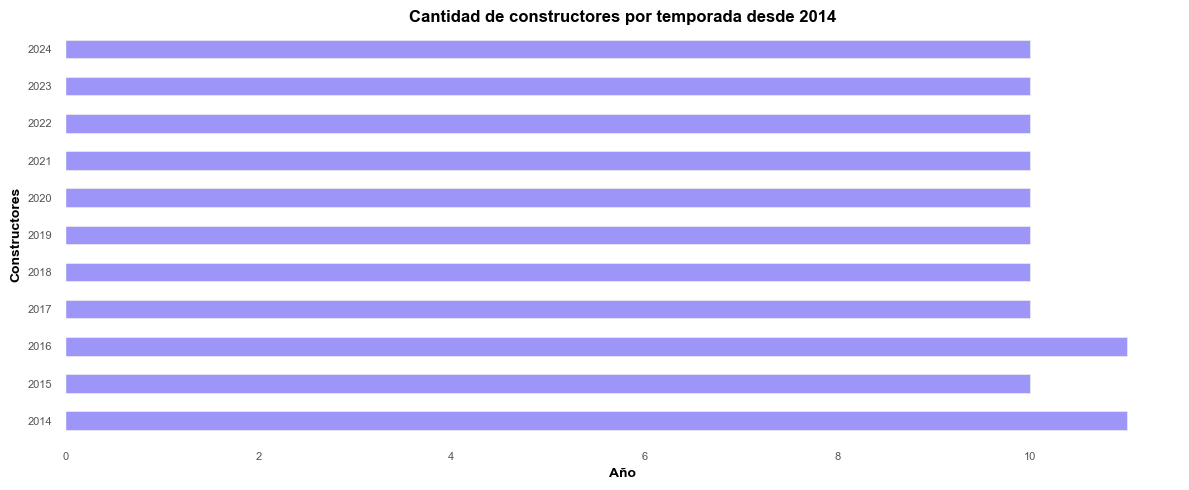

In [119]:
constructoresPorAnio = df.groupby('year')['constructorId'].nunique()

fig, ax = plt.subplots(figsize=(12, 5))
constructoresPorAnio.plot(kind='barh', color='#9E95F8', ax=ax)
ax.set_facecolor('#FFFFFF')
ax.set_title('Cantidad de constructores por temporada desde 2014', fontsize=12, fontweight='bold', color='#000000')
ax.set_xlabel('Año', fontsize=10, fontweight='bold', color='#000000')
ax.set_ylabel('Constructores', fontsize=10, fontweight='bold', color='#000000')
ax.tick_params(axis='both', labelsize=8)
ax.grid(False)
plt.tight_layout()
plt.show()



## 3.2 Análisis univariado - Variables numéricas

Objetivo: Entender la forma de la distribución

In [120]:
#Analizando variables numéricas.

numCol = df.select_dtypes(include=['int64','int32','float64']).columns
numCol


Index(['year', 'round', 'startingPosition', 'finalPosition', 'points',
       'qualyPosition', 'q1', 'q2', 'q3', 'wonRace'],
      dtype='object')

C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


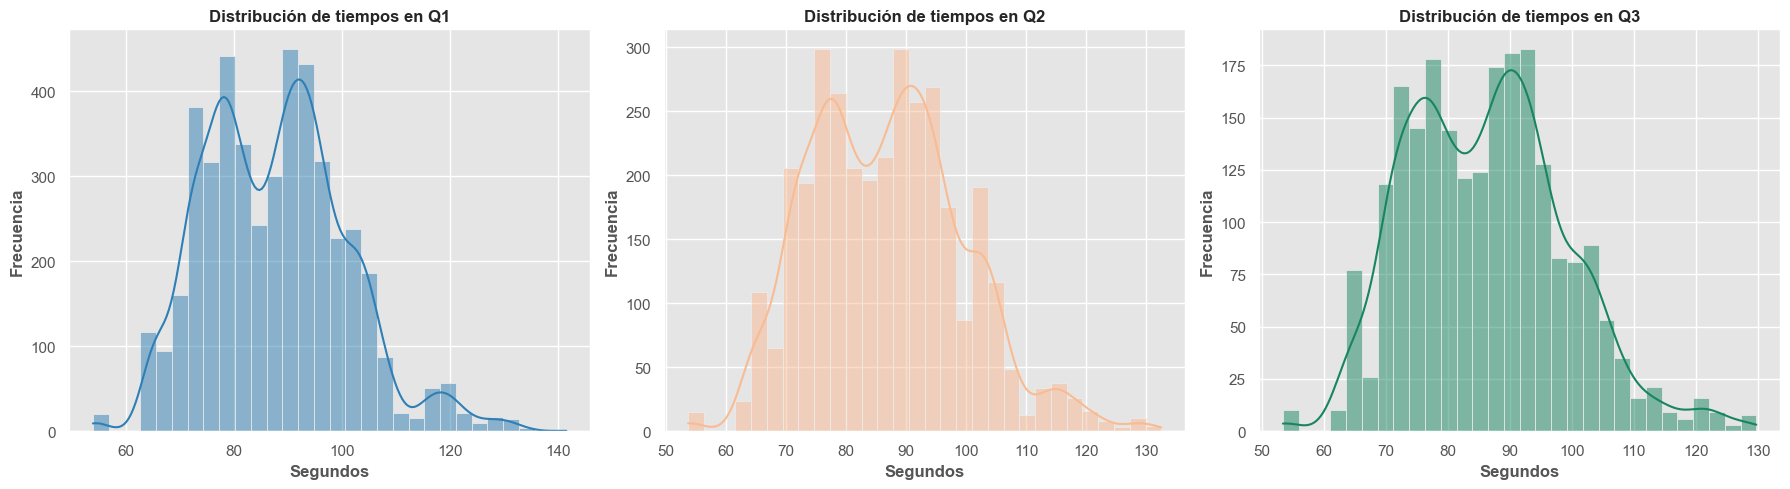

In [121]:
#Graficando 3 histplots para ver la distribución de tiempos en "q1", "q2" y "q3"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(
    df['q1'], 
    kde=True, 
    bins=30, 
    ax=axes[0], 
    color='#2E7FB5'
)

axes[0].set_title('Distribución de tiempos en Q1', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Segundos', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')

sns.histplot(df['q2'], kde=True, bins=30, ax=axes[1], color='#F9BB92')
axes[1].set_title('Distribución de tiempos en Q2', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Segundos', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')

sns.histplot(df['q3'], kde=True, bins=30, ax=axes[2], color='#178561')
axes[2].set_title('Distribución de tiempos en Q3', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Segundos', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



Las distribuciones de tiempos en Q1, Q2 y Q3 están centradas en torno a los 80-90 segundos, con vueltas atípicas por encima de los 110–120 segundos. La presencia de más de un pico sugiere diferencias claras entre grupos de rendimiento dentro de la parrilla, como equipos punteros vs equipos del fondo.

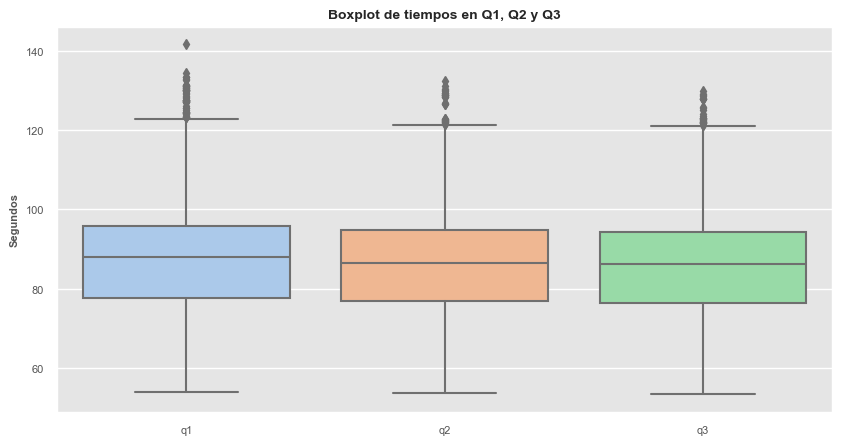

In [122]:
# Graficando un boxplot para verificar distribución de outliers

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    data=df[['q1', 'q2', 'q3']], 
    palette='pastel'
)

ax.set_title('Boxplot de tiempos en Q1, Q2 y Q3', fontsize=10, fontweight='bold')
ax.set_ylabel('Segundos', fontsize=8, fontweight='bold')
ax.tick_params(axis='both', labelsize=8)
plt.show()


Los tiempos de clasificación para Q1, Q2 y Q3 tienen distribuciones bastante similares, con medianas cercanas. Sin embargo, se detectan múltiples outliers, especialmente en el extremo superior, que podrían estar asociados a condiciones atípicas (clima, accidentes, penalizaciones, etc.).


In [123]:
# Generando una función para detectar outliers.

def detectarOutliersIqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limiteInferior = Q1 - 1.5 * IQR
    limiteSuperior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limiteInferior) | (df[columna] > limiteSuperior)]
    return outliers


In [124]:
outliersQ1 = detectarOutliersIqr(df, 'q1')
outliersQ2 = detectarOutliersIqr(df, 'q2')
outliersQ3 = detectarOutliersIqr(df, 'q3')


In [125]:
print(f"Outliers en Q1: {len(outliersQ1)}")
print(f"Outliers en Q2: {len(outliersQ2)}")
print(f"Outliers en Q3: {len(outliersQ3)}")


Outliers en Q1: 51
Outliers en Q2: 28
Outliers en Q3: 28


In [126]:
outliersQ1[['circuitName', 'driverName', 'constructorName', 'q1','q2','q3']].head(10)

,circuitName,driverName,constructorName,q1,q2,q3
341,Circuit de Spa-Francorchamps,Kimi Räikkönen,Ferrari,129.885,128.646,128.780
522,Sepang International Circuit,Kamui Kobayashi,Caterham,123.595,NaN,NaN
610,Circuit de Spa-Francorchamps,Sebastian Vettel,Red Bull,130.105,128.868,127.717
647,Circuit de Spa-Francorchamps,Marcus Ericsson,Caterham,134.438,NaN,NaN
667,Circuit de Spa-Francorchamps,Sergio Pérez,Force India,130.666,130.084,NaN
679,Circuit de Spa-Francorchamps,Nico Hülkenberg,Haas F1 Team,123.166,NaN,NaN
841,Istanbul Park,Antonio Giovinazzi,Alfa Romeo,127.341,113.431,117.226
1028,Jeddah Corniche Circuit,Logan Sargeant,Williams,128.510,NaN,NaN
1045,Circuit de Spa-Francorchamps,Jenson Button,McLaren,130.529,129.272,129.776
1139,Istanbul Park,Sergio Pérez,Racing Point,127.614,114.097,109.321


In [127]:
outliersQ2[['circuitName', 'driverName', 'constructorName', 'q1','q2','q3']].head(10)

,circuitName,driverName,constructorName,q1,q2,q3
158,Sepang International Circuit,Romain Grosjean,Lotus F1,120.202,122.885,NaN
264,Sepang International Circuit,Daniil Kvyat,Toro Rosso,121.175,122.351,NaN
341,Circuit de Spa-Francorchamps,Kimi Räikkönen,Ferrari,129.885,128.646,128.780
387,Sepang International Circuit,Sergio Pérez,Force India,120.076,122.511,NaN
610,Circuit de Spa-Francorchamps,Sebastian Vettel,Red Bull,130.105,128.868,127.717
667,Circuit de Spa-Francorchamps,Sergio Pérez,Force India,130.666,130.084,NaN
1045,Circuit de Spa-Francorchamps,Jenson Button,McLaren,130.529,129.272,129.776
1296,Circuit de Spa-Francorchamps,Romain Grosjean,Lotus F1,130.898,131.087,NaN
1454,Circuit de Spa-Francorchamps,Lewis Hamilton,Mercedes,127.280,126.609,125.819
1489,Sepang International Circuit,Felipe Massa,Williams,120.047,122.460,NaN


In [128]:
outliersQ3[['circuitName', 'driverName', 'constructorName', 'q1','q2','q3']].head(10)

,circuitName,driverName,constructorName,q1,q2,q3
341,Circuit de Spa-Francorchamps,Kimi Räikkönen,Ferrari,129.885,128.646,128.780
373,Circuit de Spa-Francorchamps,Sergio Pérez,Red Bull,119.334,116.886,122.112
532,Silverstone Circuit,Nicholas Latifi,Williams,101.998,103.273,123.095
610,Circuit de Spa-Francorchamps,Sebastian Vettel,Red Bull,130.105,128.868,127.717
721,Circuit de Spa-Francorchamps,Kimi Räikkönen,Ferrari,102.585,101.533,122.671
1045,Circuit de Spa-Francorchamps,Jenson Button,McLaren,130.529,129.272,129.776
1454,Circuit de Spa-Francorchamps,Lewis Hamilton,Mercedes,127.280,126.609,125.819
1631,Circuit de Spa-Francorchamps,Romain Grosjean,Haas F1 Team,103.597,103.042,122.122
1781,Circuit de Spa-Francorchamps,Nico Rosberg,Mercedes,127.130,126.723,125.591
1824,Circuit de Spa-Francorchamps,Daniel Ricciardo,Red Bull,130.089,128.989,127.911


In [129]:
# Concatenando los 3 DataFrames de outliers
outliersTotal = pd.concat([outliersQ1, outliersQ2, outliersQ3])

# Contando cuántas veces aparece cada piloto
topPilotos = outliersTotal['driverName'].value_counts().head(10)

print("Top 10 pilotos con más outliers:")
print(topPilotos)


Top 10 pilotos con más outliers:
driverName
Kimi Räikkönen      7
Sergio Pérez        7
Kevin Magnussen     7
Valtteri Bottas     6
Jenson Button       5
Daniel Ricciardo    5
Romain Grosjean     5
Lewis Hamilton      5
Daniil Kvyat        4
Sebastian Vettel    4
Name: count, dtype: int64


In [130]:
topEquipos = outliersTotal['constructorName'].value_counts().head(10)

print("Top 10 equipos con más outliers:")
print(topEquipos)


Top 10 equipos con más outliers:
constructorName
Williams        12
McLaren         12
Ferrari         11
Red Bull        10
Mercedes        10
Toro Rosso       8
Force India      7
Haas F1 Team     7
Sauber           5
Lotus F1         5
Name: count, dtype: int64


C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


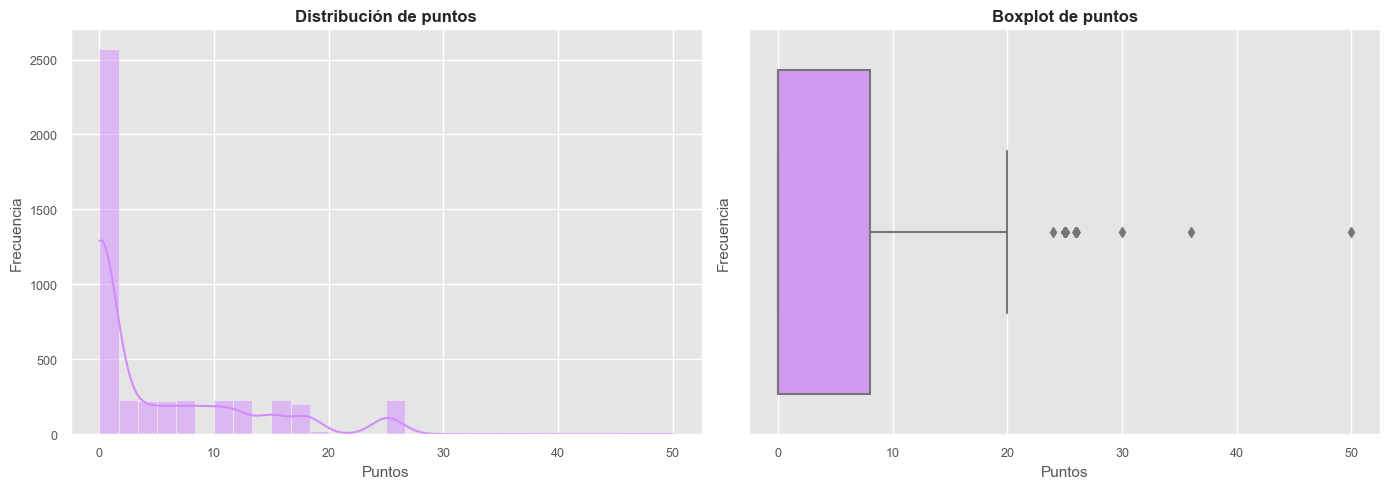

In [131]:
#Graficando para verificar distribución de puntos

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(
    df['points'], 
    bins=30, 
    kde=True, 
    ax=axes[0], 
    color='#D28CFE'
)

axes[0].set_title('Distribución de puntos', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Puntos', fontsize=11)
axes[0].set_ylabel('Frecuencia',fontsize=11)
axes[0].tick_params(axis='both', labelsize=9)

sns.boxplot(
    x=df['points'], 
    ax=axes[1], 
    color='#D28CFE'
)

axes[1].set_title('Boxplot de puntos', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Puntos', fontsize=11)
axes[1].set_ylabel('Frecuencia',fontsize=11)
axes[1].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()


In [132]:
outliersPoints = detectarOutliersIqr(df, 'points')

print(f"{len(outliersPoints)}")


230


In [133]:
print("Top 5 pilotos con más outliers en puntos:")
print(outliersPoints['driverName'].value_counts().head(5))

print("Top 5 equipos con más outliers en puntos:")
print(outliersPoints['constructorName'].value_counts().head(5))


Top 5 pilotos con más outliers en puntos:
driverName
Lewis Hamilton      83
Max Verstappen      62
Nico Rosberg        20
Sebastian Vettel    14
Valtteri Bottas     11
Name: count, dtype: int64
Top 5 equipos con más outliers en puntos:
constructorName
Mercedes    116
Red Bull     75
Ferrari      27
McLaren       7
Williams      2
Name: count, dtype: int64


C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


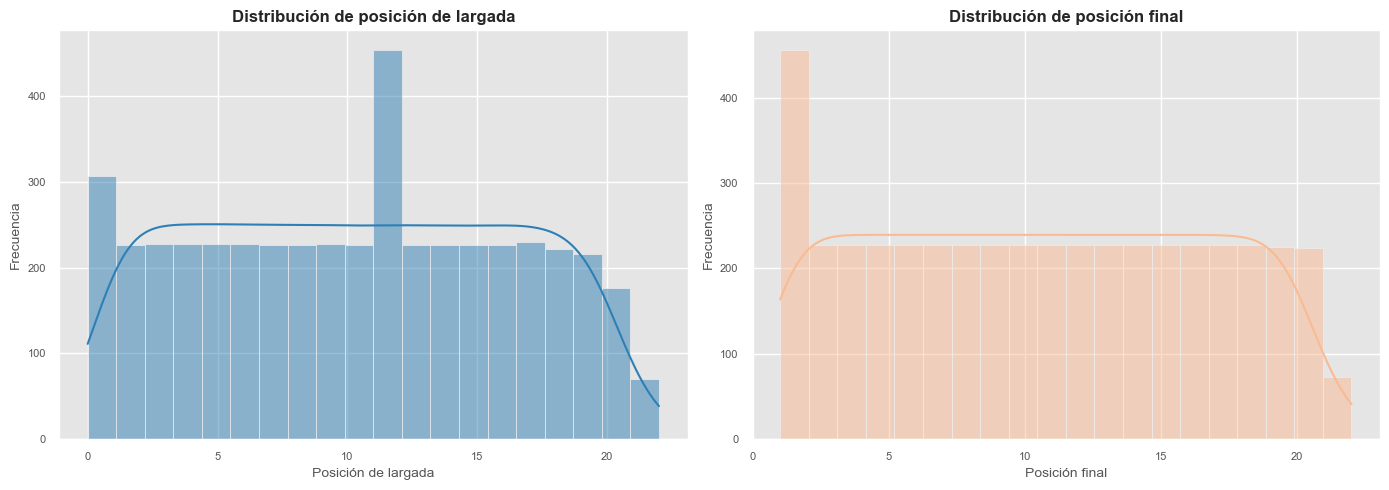

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Posición de largada
sns.histplot(
    df['startingPosition'], 
    bins=20, 
    kde=True, 
    color='#2E7FB5', 
    ax=axes[0]
)

axes[0].set_title('Distribución de posición de largada', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Posición de largada', fontsize=10)
axes[0].set_ylabel('Frecuencia', fontsize=10)
axes[0].tick_params(axis='both', labelsize=8)

# Posición final
sns.histplot(
    df['finalPosition'], 
    bins=20, 
    kde=True, 
    color='#F9BB92', 
    ax=axes[1]
)

axes[1].set_title('Distribución de posición final', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Posición final', fontsize=10)
axes[1].set_ylabel('Frecuencia', fontsize=10)
axes[1].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()



## 3.3 Análisis bivariado

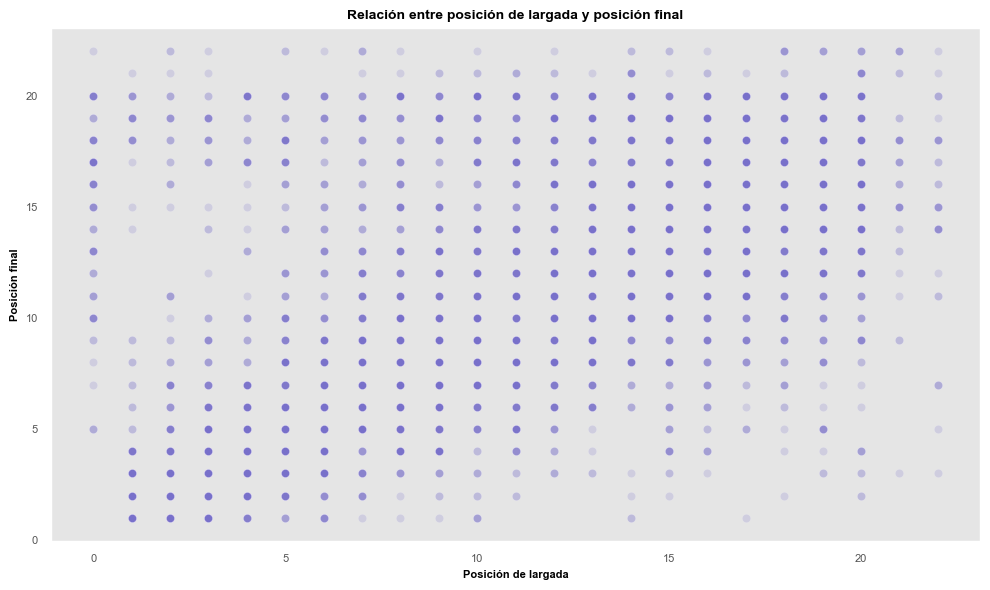

In [135]:
# Graficando un scatterplot para ver la relación entre startingPosition y finalPosition.


fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x='startingPosition',
    y='finalPosition',
    color='#7870CA',
    alpha=0.2,
    ax=ax
)

ax.set_title('Relación entre posición de largada y posición final', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Posición de largada', fontsize=8, color='#000000', fontweight='bold')
ax.set_ylabel('Posición final', fontsize=8, color='#000000', fontweight='bold')
ax.tick_params(axis='both', labelsize=8)

ax.grid(False)


plt.tight_layout()
plt.show()



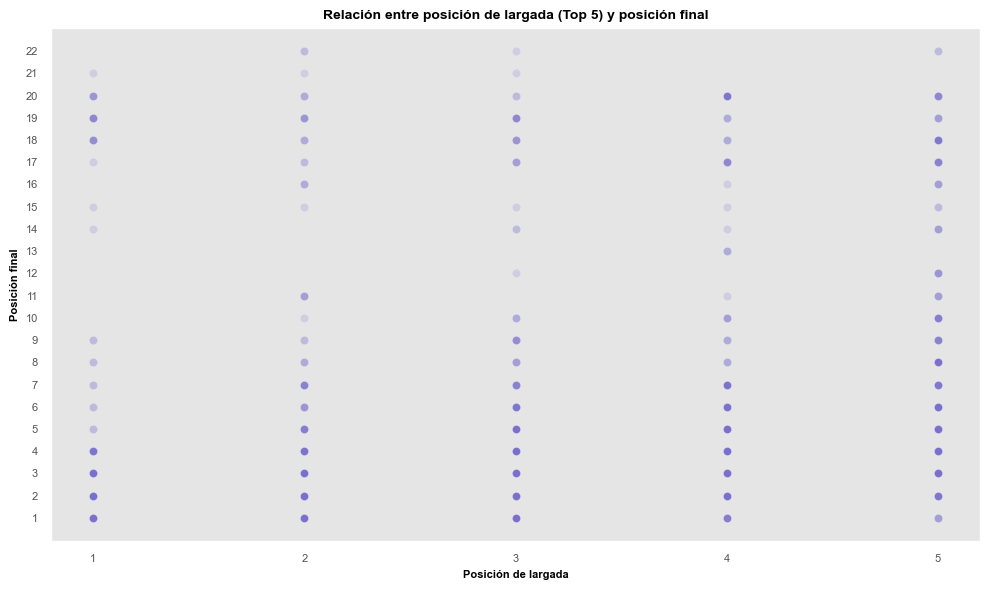

In [136]:
# Graficando un scatterplot para ver la relación entre startingPosition y finalPosition 
# filtrando pilotos que larguen en las primeras 5 posiciones 
# para verificar si existe una correlación positiva con la posición final.

dfTop5 = df[(df['startingPosition'] > 0) & (df['startingPosition'] <= 5)]
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=dfTop5,
    x='startingPosition',
    y='finalPosition',
    color='#7870CA',
    alpha=0.2,
    ax=ax
)

ax.set_title('Relación entre posición de largada (Top 5) y posición final', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Posición de largada', fontsize=8, color='#000000', fontweight='bold')
ax.set_ylabel('Posición final', fontsize=8, color='#000000', fontweight='bold')
ax.tick_params(axis='both', labelsize=8)
ax.grid(False)
ax.set_xticks(range(1, 6))
ax.set_yticks(range(1, 23))

plt.tight_layout()
plt.show()



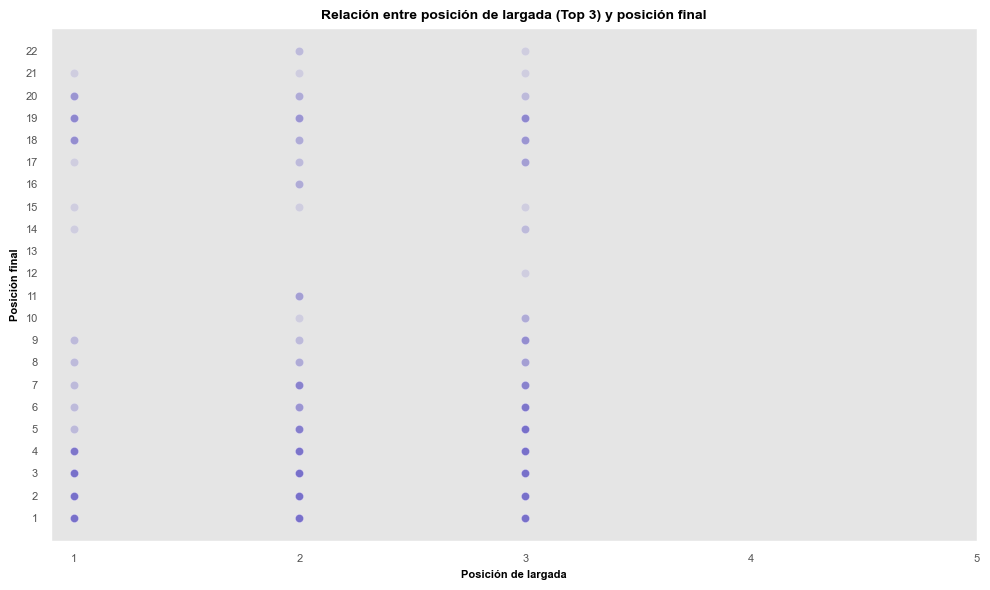

In [137]:
# Graficando un scatterplot para ver la relación entre startingPosition y finalPosition 
# filtrando pilotos que larguen en las primeras 3 posiciones 
# para verificar si existe una correlación positiva con la posición final.

dfTop3 = df[(df['startingPosition'] > 0) & (df['startingPosition'] <= 3)]
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=dfTop3,
    x='startingPosition',
    y='finalPosition',
    color='#7870CA',
    alpha=0.2,
    ax=ax
)

ax.set_title('Relación entre posición de largada (Top 3) y posición final', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Posición de largada', fontsize=8, color='#000000', fontweight='bold')
ax.set_ylabel('Posición final', fontsize=8, color='#000000', fontweight='bold')
ax.tick_params(axis='both', labelsize=8)
ax.grid(False)
ax.set_xticks(range(1, 6))
ax.set_yticks(range(1, 23))

plt.tight_layout()
plt.show()

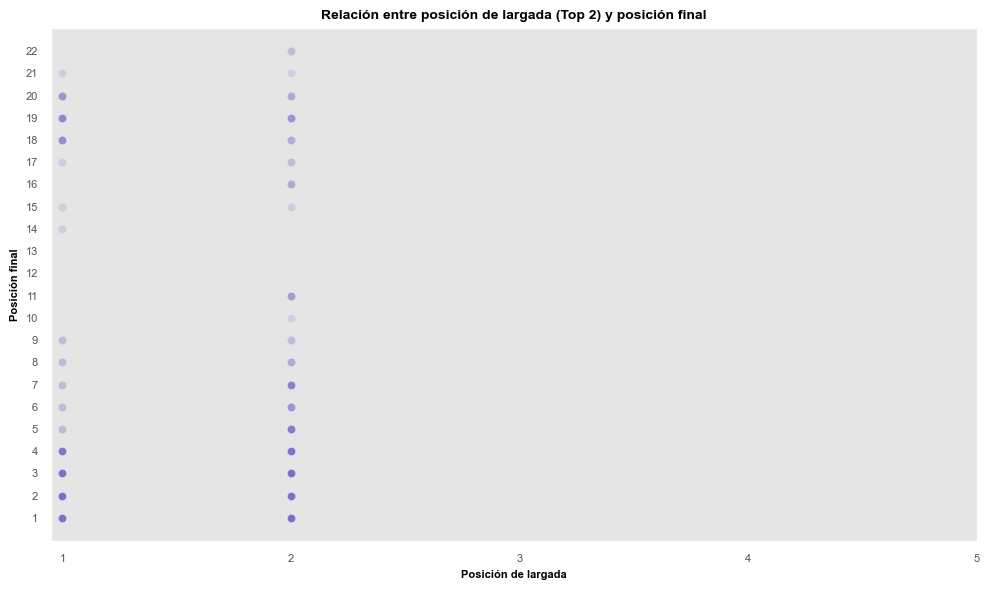

In [138]:
# Graficando un scatterplot para ver la relación entre startingPosition y finalPosition 
# filtrando pilotos que larguen en las primeras 2 posiciones 
# para verificar si existe una correlación positiva con la posición final.

dfTop2 = df[(df['startingPosition'] > 0) & (df['startingPosition'] <= 2)]
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=dfTop2,
    x='startingPosition',
    y='finalPosition',
    color='#7870CA',
    alpha=0.2,
    ax=ax
)

ax.set_title('Relación entre posición de largada (Top 2) y posición final', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Posición de largada', fontsize=8, color='#000000', fontweight='bold')
ax.set_ylabel('Posición final', fontsize=8, color='#000000', fontweight='bold')
ax.tick_params(axis='both', labelsize=8)
ax.grid(False)
ax.set_xticks(range(1, 6))
ax.set_yticks(range(1, 23))

plt.tight_layout()
plt.show()

In [139]:
corr = df[['startingPosition', 'finalPosition']].corr().iloc[0, 1]
corrTop5 = dfTop5[['startingPosition', 'finalPosition']].corr().iloc[0, 1]
corrTop3 = dfTop3[['startingPosition', 'finalPosition']].corr().iloc[0, 1]
corrTop2 = dfTop2[['startingPosition', 'finalPosition']].corr().iloc[0, 1]

print(f"Correlación entre posición de largada y final: {corr:.2f}")
print(f"Correlación entre posición de largada y final (Top 5): {corrTop5:.2f}")
print(f"Correlación entre posición de largada y final (Top 3): {corrTop3:.2f}")
print(f"Correlación entre posición de largada y final (Top 2): {corrTop2:.2f}")


Correlación entre posición de largada y final: 0.57
Correlación entre posición de largada y final (Top 5): 0.28
Correlación entre posición de largada y final (Top 3): 0.13
Correlación entre posición de largada y final (Top 2): 0.07


La hipótesis 1 planteada sostiene que la posición de largada tiene correlación positiva con la posición final. Según los resultados obtenidos, esta hipótesis se cumple cuando se analizan todos los pilotos, ya que se observa una correlación positiva moderada (r = 0.57), lo que indica que cuanto más adelante larga un piloto, mejores son sus probabilidades de terminar en una buena posición.

Sin embargo, al enfocar el análisis en los pilotos que terminan en las posiciones más altas (Top 5, Top 3 y Top 2), la fuerza de esta correlación disminuye considerablemente (r = 0.28, 0.13 y 0.07 respectivamente). Esto sugiere que si bien la posición de largada influye en el resultado, entre los pilotos más competitivos entran en juego otros factores decisivos como la estrategia de carrera, las paradas en boxes, las condiciones climáticas y el ritmo general durante la competencia.

En resumen, la hipótesis se valida a nivel general, pero pierde fuerza en los primeros puestos, donde otros elementos tienen un mayor peso en el resultado final.

In [140]:
df['elimEnQ1'] = df['q2'].isna()

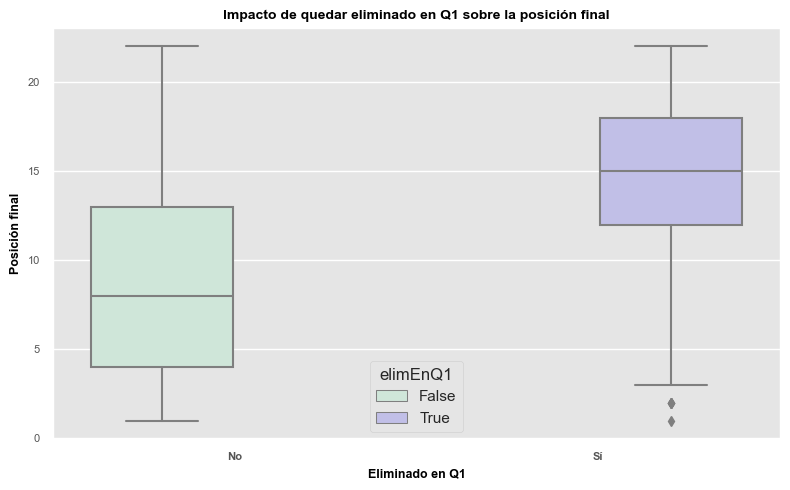

In [141]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(
    data=df,
    x='elimEnQ1',
    y='finalPosition',
    hue='elimEnQ1',
    palette={True: '#BBB9ED', False: '#CBEAD9'},
    ax=ax
)


ax.set_title('Impacto de quedar eliminado en Q1 sobre la posición final', fontsize=10, fontweight='bold', color='#000000')
ax.set_xlabel('Eliminado en Q1', fontsize=9, fontweight='bold', color='#000000')
ax.set_ylabel('Posición final', fontsize=9, fontweight='bold', color='#000000')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Sí'], fontsize=8, fontweight='bold')
ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

Los pilotos que no quedaron eliminados en Q1 (grupo "No") tienen una mediana de posición final más baja (mejor posición) y una dispersión mayor, con posiciones finales que varían desde muy buenas (cerca de 1) hasta posiciones más altas (peores).

Los pilotos que sí quedaron eliminados en Q1 (grupo "Sí") tienden a tener posiciones finales más altas (peores), con una mediana cerca de la posición 15.

Se puede ver que hay algunos outliers en el grupo de eliminados que terminaron en posiciones muy bajas (mejores), lo que podría indicar que algunos pilotos, a pesar de quedar eliminados en Q1, terminaron la carrera en buenas posiciones.

Por lo tanto, se evidencia lo planteado en la hipotesis 2 (Los pilotos que no pasan la Q1 tienden a terminar en peores posiciones finales) ya que se observa que quedar eliminado en Q1 tiene un impacto negativo en la posición final, ya que los eliminados terminan en posiciones más retrasadas en promedio.


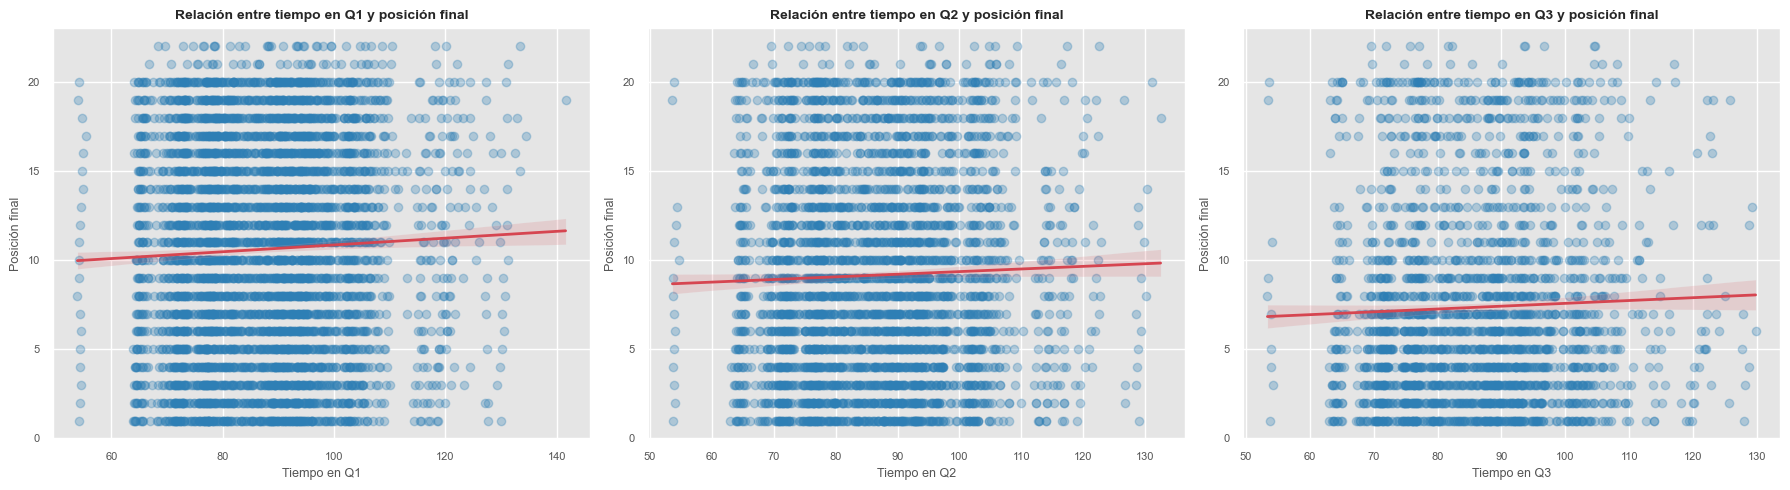

In [142]:
# Verificando si un mejor tiempo en la Q1, Q2 y Q3 tiene correlación positiva con la posición final en la carrera
dfQ1 = df[['q1', 'finalPosition']].dropna()
dfQ2 = df[['q2', 'finalPosition']].dropna()
dfQ3 = df[['q3', 'finalPosition']].dropna()

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

sns.regplot(
    data=dfQ1,
    x='q1',
    y='finalPosition',
    scatter_kws={'alpha': 0.3, 'color': '#2E7FB5'},
    line_kws={'color': '#D64550', 'linewidth': 2},
    ax=axes[0]
)
axes[0].set_title('Relación entre tiempo en Q1 y posición final', fontsize=10, fontweight='bold')
axes[0].set_xlabel('Tiempo en Q1', fontsize=9)
axes[0].set_ylabel('Posición final', fontsize=9)
axes[0].tick_params(axis='both', labelsize=8)
axes[0].grid(True)

sns.regplot(
    data=dfQ2,
    x='q2',
    y='finalPosition',
    scatter_kws={'alpha': 0.3, 'color': '#2E7FB5'},
    line_kws={'color': '#D64550', 'linewidth': 2},
    ax=axes[1]
)
axes[1].set_title('Relación entre tiempo en Q2 y posición final', fontsize=10, fontweight='bold')
axes[1].set_xlabel('Tiempo en Q2', fontsize=9)
axes[1].set_ylabel('Posición final', fontsize=9)
axes[1].tick_params(axis='both', labelsize=8)
axes[1].grid(True)


sns.regplot(
    data=dfQ3,
    x='q3',
    y='finalPosition',
    scatter_kws={'alpha': 0.3, 'color': '#2E7FB5'},
    line_kws={'color': '#D64550', 'linewidth': 2},
    ax=axes[2]
)
axes[2].set_title('Relación entre tiempo en Q3 y posición final', fontsize=10, fontweight='bold')
axes[2].set_xlabel('Tiempo en Q3', fontsize=9)
axes[2].set_ylabel('Posición final', fontsize=9)
axes[2].tick_params(axis='both', labelsize=8)
axes[2].grid(True)


plt.tight_layout()
plt.show()


In [143]:
correlacionQ1Final = dfQ1.corr().iloc[0, 1]
correlacionQ2Final = dfQ2.corr().iloc[0, 1]
correlacionQ3Final = dfQ3.corr().iloc[0, 1]

print(f"Correlación entre Q1 y posición final: {correlacionQ1Final:.3f}")
print(f"Correlación entre Q2 y posición final: {correlacionQ2Final:.3f}")
print(f"Correlación entre Q3 y posición final: {correlacionQ3Final:.3f}")

Correlación entre Q1 y posición final: 0.043
Correlación entre Q2 y posición final: 0.033
Correlación entre Q3 y posición final: 0.037


El análisis realizado muestra que los tiempos de clasificación en las sesiones Q1, Q2 y Q3 tienen una correlación muy baja con la posición final en la carrera, lo que indica que un mejor desempeño en la clasificación no garantiza un mejor resultado en la competencia.

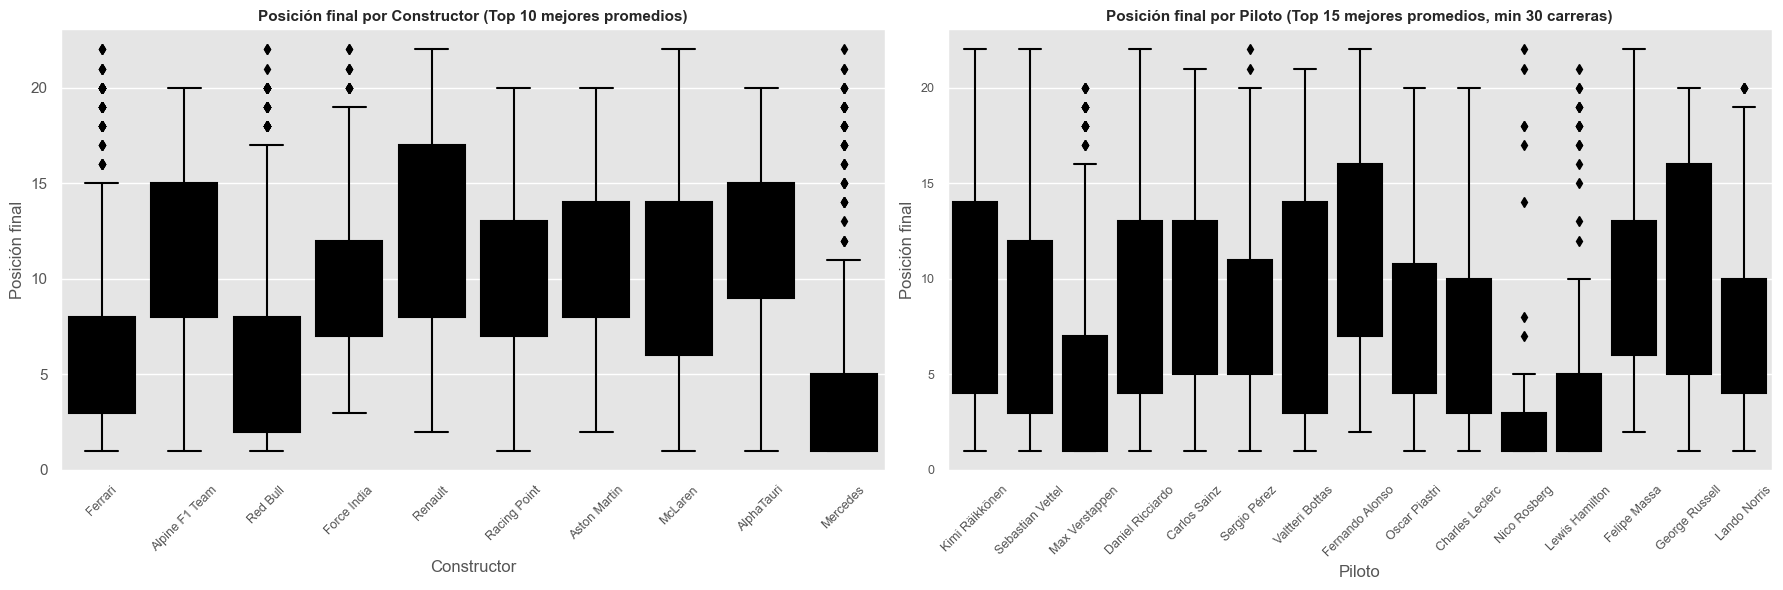

In [144]:
# Analizando los constructores y pilotos con mejor promedio de posición final
promediosConstructor = df.groupby('constructorName')['finalPosition'].mean().sort_values()
topConstructors = promediosConstructor.head(10).index

conteoPilotos = df['driverName'].value_counts()
pilotosFiltrados = conteoPilotos[conteoPilotos >= 30].index
promediosPiloto = df[df['driverName'].isin(pilotosFiltrados)].groupby('driverName')['finalPosition'].mean().sort_values()
topPilotos = promediosPiloto.head(15).index

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot constructores
sns.boxplot(
    data=df[df['constructorName'].isin(topConstructors)],
    x='constructorName',
    y='finalPosition',
    ax=axes[0],
    color='#000000'
)
axes[0].set_title('Posición final por Constructor (Top 10 mejores promedios)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Constructor')
axes[0].set_ylabel('Posición final')
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)

# Boxplot pilotos
sns.boxplot(
    data=df[df['driverName'].isin(topPilotos)],
    x='driverName',
    y='finalPosition',
    ax=axes[1],
    color='#000000'
)
axes[1].set_title('Posición final por Piloto (Top 15 mejores promedios, min 30 carreras)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Piloto')
axes[1].set_ylabel('Posición final')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()


## 3.4 Análisis multivariados

Objetivo: Entender cómo combinaciones de variables afectan la probabilidad de que un piloto gane una carrera

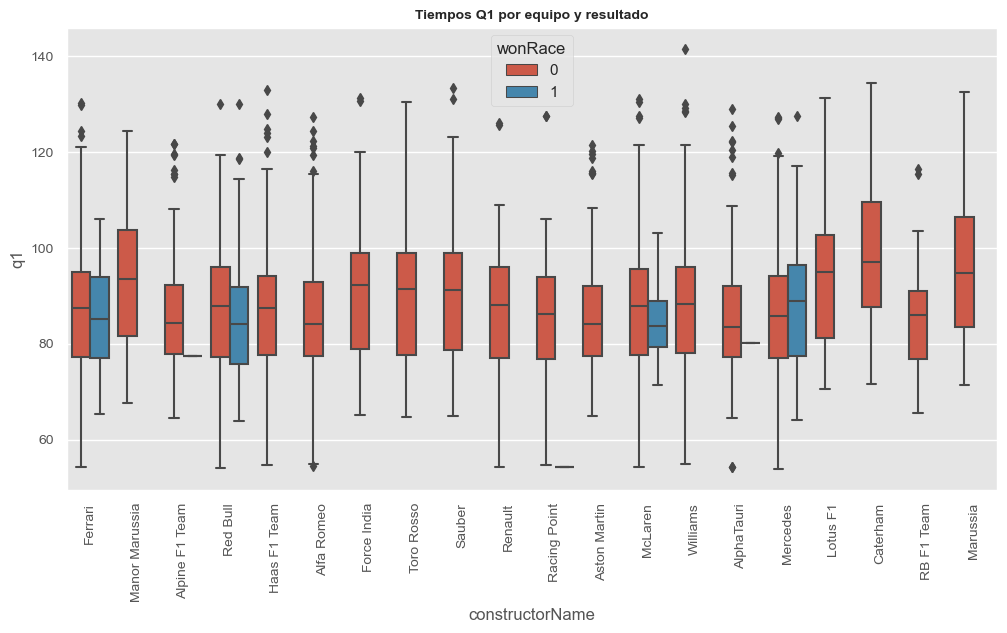

In [170]:
#Graficando un boxplot para verificar si hay los pilotos que ganan tienden a tener mejores resultados en la q1

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df, x='constructorName', y='q1', hue='wonRace', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Tiempos Q1 por equipo y resultado", fontsize=10, fontweight='bold')
ax.tick_params(axis='both', labelsize=10)

plt.show()


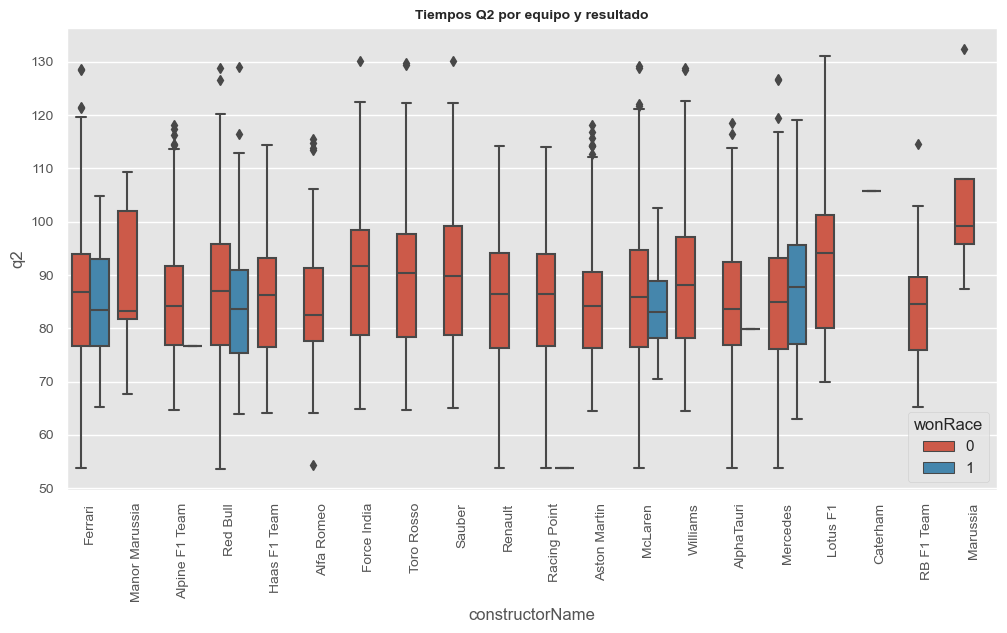

In [177]:
#Graficando un boxplot para verificar si hay los pilotos que ganan tienden a tener mejores resultados en la q2

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df, x='constructorName', y='q2', hue='wonRace', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Tiempos Q2 por equipo y resultado", fontsize=10, fontweight='bold')
ax.tick_params(axis='both', labelsize=10)

plt.show()

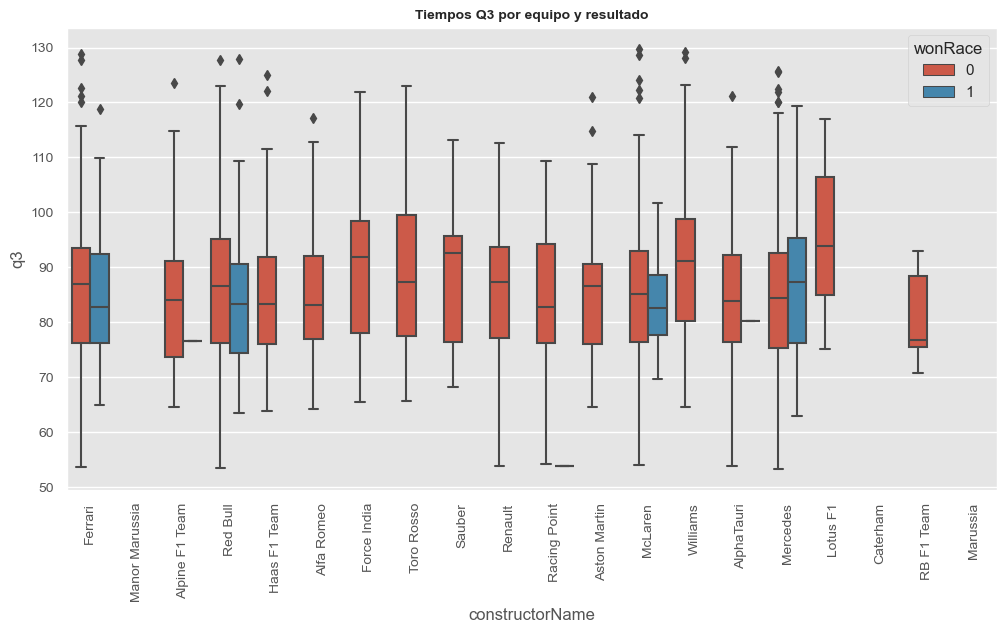

In [173]:
#Graficando un boxplot para verificar si hay los pilotos que ganan tienden a tener mejores resultados en la q3

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df, x='constructorName', y='q3', hue='wonRace', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Tiempos Q3 por equipo y resultado", fontsize=10, fontweight='bold')
ax.tick_params(axis='both', labelsize=10)

plt.show()

# 4. Modelo

In [145]:
# Verificando columnas disponibles
df.columns


Index(['raceId', 'year', 'round', 'raceDate', 'circuitName', 'circuitLocation',
       'circuitCountry', 'driverId', 'driverName', 'driverNationality',
       'driverBirthdate', 'constructorId', 'constructorName',
       'constructorNationality', 'startingPosition', 'finalPosition',
       'positionText', 'points', 'status', 'qualyPosition', 'q1', 'q2', 'q3',
       'wonRace', 'elimEnQ1'],
      dtype='object')

In [146]:

# Preparación de los datos

# Seleccionando las features más relevantes
features = [
    'year',
    'round',
    'startingPosition',
    'q1', 
    'q2', 
    'q3',
    'constructorName',
    'driverName',
    'driverNationality',
    'elimEnQ1',
]

# Seleccionando el target
target = 'wonRace'

# Creando un nuevo DataFrame con solo las columnas necesarias
dfModel = df[features + [target]].copy()

# Eliminando filas con valores faltantes
dfModel = dfModel.dropna()

# Codificando variables categóricas con One Hot Encoding
dfModelEncoded = pd.get_dummies(dfModel, columns=[
    'constructorName',
    'driverName',
    'driverNationality',
], drop_first=True)

In [147]:
# Dividiendo los datos

from sklearn.model_selection import train_test_split

X = dfModelEncoded.drop(columns=[target])
y = dfModelEncoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Entrenando el modelo con clase balanceada
logreg_balanced = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
logreg_balanced.fit(X_train, y_train)

# Probabilidades para la clase 1 ("ganó")
y_proba_log = logreg_balanced.predict_proba(X_test)[:, 1]

# Umbral
threshold = 0.80

# Predicciones con umbral personalizado
y_pred_threshold = (y_proba_log >= threshold).astype(int)


Cálculo de métricas numéricas

In [149]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_threshold))

# --- Matriz de Confusión ---
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred_threshold)
print(cm)

# --- Accuracy ---
accuracy = accuracy_score(y_test, y_pred_threshold)
print(f"\nAccuracy: {accuracy:.2%}")

# --- ROC AUC Score ---
roc_auc = roc_auc_score(y_test, y_proba_log)
print(f"ROC AUC: {roc_auc:.4f}")



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       398
           1       0.52      0.62      0.57        45

    accuracy                           0.90       443
   macro avg       0.74      0.78      0.76       443
weighted avg       0.91      0.90      0.91       443


--- Matriz de Confusión ---
[[372  26]
 [ 17  28]]

Accuracy: 90.29%
ROC AUC: 0.9065


Visualización de resultados

C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ignac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


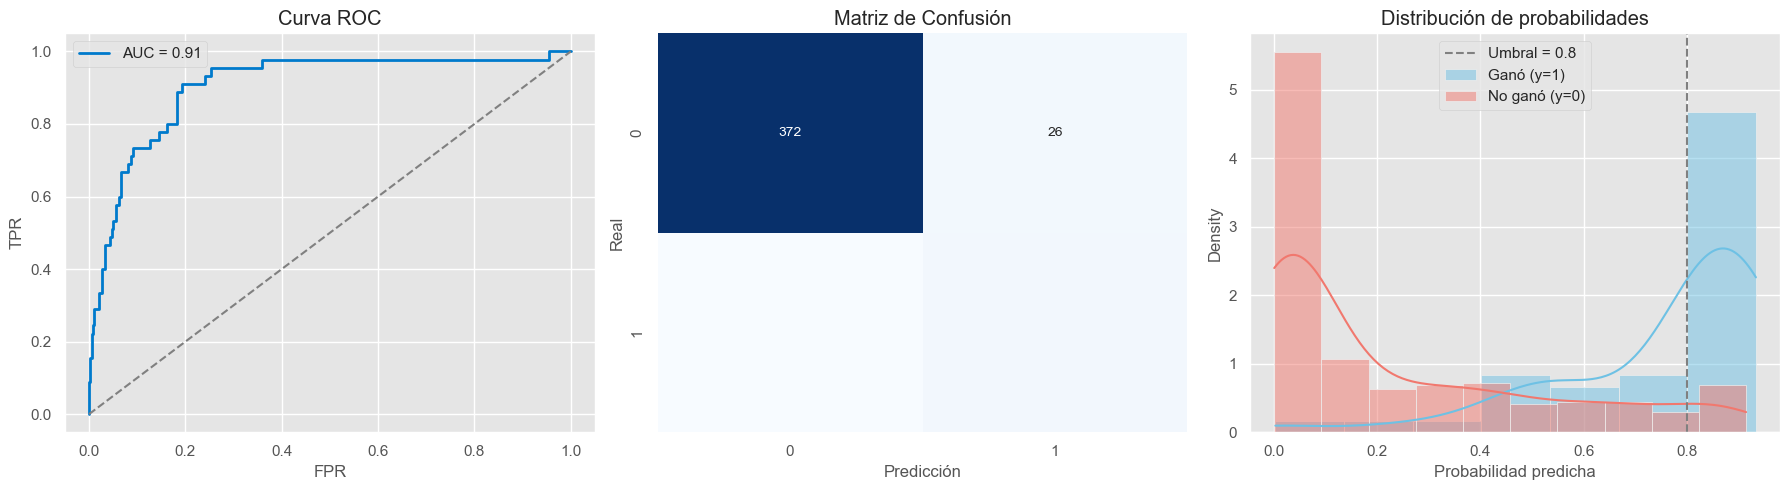

In [150]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='#007ACC', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred_threshold)
plt.subplot(1, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')

# --- Distribución de probabilidades ---
plt.subplot(1, 3, 3)
sns.histplot(y_proba_log[y_test == 1], color='#6EC1E4', label='Ganó (y=1)', kde=True, stat='density')
sns.histplot(y_proba_log[y_test == 0], color='#F1786E', label='No ganó (y=0)', kde=True, stat='density')
plt.axvline(threshold, color='gray', linestyle='--', label=f'Umbral = {threshold}')
plt.xlabel('Probabilidad predicha')
plt.title('Distribución de probabilidades')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# 5. Conclusiones y trabajos futuros

El objetivo del proyecto era desarrollar un modelo de machine learning capaz de predecir si un piloto ganará una carrera de Fórmula 1, utilizando información previa a la competencia como los resultados de clasificación (Q1, Q2, Q3), la posición de largada y variables relacionadas al piloto y la escudería.

## Resultados del modelo:

Tras eliminar variables poco relevantes y ajustar el umbral de decisión, se obtuvo un modelo de clasificación con los siguientes resultados:

- Accuracy general: 90.3%

- ROC AUC: 0.91

- Precision (ganadores): 52%

- Recall (ganadores): 62%

- F1-score (ganadores): 0.57

El modelo logró detectar correctamente 28 de los 45 ganadores reales en el conjunto de test (recall = 62%), con un buen balance entre falsos positivos y falsos negativos.

## Aprendizajes clave

- El rendimiento del modelo mejoró significativamente al eliminar variables poco relevantes.

- El uso de class_weight='balanced' y el ajuste del umbral de decisión permitieron mejorar el desempeño.


## Recomendaciones futuras

Como primer acercamiento al modelado predictivo en Fórmula 1, los resultados obtenidos son positivos. Sin embargo, dada la complejidad del deporte, donde influyen factores como cambios en el reglamento, evolución tecnológica de los autos, condiciones climáticas y características particulares de cada circuito, el proyecto tiene un amplio potencial de mejora para aumentar su precisión y capacidad de generalización.

Posibles mejoras a futuro:

- Agregar variables históricas por piloto y constructor: Incorporar información como cantidad de victorias en la temporada, promedio de clasificación, cantidad de abandonos, desempeño en circuitos específicos, entre otros. Esto permitiría que el modelo capte tendencias individuales y contextuales.

- Incluir estadísticas particulares de cada circuito: Analizar cómo suelen variar las posiciones en distintos trazados, qué tan determinante es la pole position según el circuito, frecuencia de abandonos, impacto del DRS, etc.

- Desarrollar modelos más avanzados Explorar algoritmos más potentes como XGBoost, Gradient Boosting Machines o redes neuronales, que pueden capturar relaciones no lineales más complejas entre variables.

- Ampliar la base de datos histórica: Integrar más temporadas para aumentar la cantidad y diversidad de registros. Esto no solo mejora el entrenamiento del modelo, sino también su capacidad de generalizar a nuevas carreras y contextos.

## Conclusión general
El modelo desarrollado representa una base sólida para la predicción de ganadores en Fórmula 1 utilizando datos disponibles antes de la carrera. Si bien aún existen oportunidades de mejora, los resultados actuales demuestran que es posible anticipar con razonable precisión qué piloto tiene mayores chances de ganar, lo que abre la puerta a aplicaciones prácticas en análisis deportivo, simulación de estrategias o entretenimiento.